# Self-driving car Nano Degree: Advanced Lane Lines

## Project feeling

The size of functions and other code sections was becoming too large to work comfortably in jupyter notebook. This useful tool is not an integrated development environment and the whole python experience was made less pleasant by the absence of advanced development tools, in particular debuggers and the ability to run code step-by-step. I really felt trapped in a distant past, where the main debugging tool was "PRINT". I was able to Trace the code, and with an object oriented library, the couple of times when I needed to do that really made the difference between giving up and finishing. Python is much more complex than it first appears.

Regarding the advanced lane lines project itself, I think it can be improved a lot for future students, and so can the course leading to it. The shortcomings from the course weight on the project and make it very academic in nature.

Let's summarize the project:

* Compute the camera calibration and apply distortion correction to images;
* Use color selection and masking to find lane line pixels on images;
* Use gradient approaches to find the lane lines;
* Warp image to bird-eye view in order to extract the geometry without the perspective effect;
* Render the extracted geometry and map it back on the original image;
* Compute the road curvature using the extracted geometry;
* Loop to process videos, and possibly include information from recent images in the detection tool chain.

This project was for me the good time to gather all the code snippets from the course and from previous projects in a single library. You will see below that camera calibration excepted, all the other steps in the project are reduced to one liners. As a beginner in Python, I had to learn many remaining areas of the language, beginning with Python classes.

I believe that this part of the course puts too much emphasis on colorspaces, without clearly making the point. Students understand what colorspaces are (I already knew), but the course does not explain how they connect with the topic. That's where we are left to believe that a robust lane detection algorithm can be built using colorspaces to look at different representations of pixel data. But that's plain wrong and misleading.

In the first lane lanes project, we boxed interesting pixels in a cube in RGB space. The tree on the side of the road projected a shadow which turned the white in gray, and it was difficult to continue tracking. So what are the more advanced methods of this project offering ?

Colorspaces index the available colors in different ways. Many tend to have hue and/or luminosity / luminance as axes. If we want to be robust to shadows, we need a rather large box in RGB space. The diagonal of that box extends from the bright white or yellow of a sunlit line, to the darker shade of the same color seen in a shadow. In different colorspaces, the boundaries defined by thresholds on various axes define other types of surfaces than cube faces in RGB space. But at the end of the process, we just delimited a volume in the colorspace (however you index it), which corresponds to "yellow" and "white" lane line pixels seen in various conditions. Using multiple colorspaces enables us to refine the definition of this volume, using separation surfaces which are not parallel to a constant R, a constant G or a constant B plane. So what ?

The academic side of the approach shows when it becomes apparent that any surface in a scene, can appear in any color if we put it under an appropriate, colored, powerful enough light source. For instance, lit by the intense red light of a laser pointer, all the surfaces appear red. The course lacks an in-depth discussion of what color is, and why an approach in the colorspaces cannot work in real life. It can only work on sunny days.

Unless we can detect the color of the dominant light sources and can compensate, the lane lines can appear in any arbitrary color. This effect is clearly visible in neon lit street scenes under the rain: the ground reflects the colored neons more than the lines show. But even in sunlight, we could have a color altering medium between the camera and the line, for instance a cloud of bluish engine exhaust, and the more we try to narrow what yellow and white mean for lane lines, the less robust we are to lighting, colored gases and rain, and paint color variations. Here we also have blue lines delimiting time-limited parking spaces.

And of course, when the theory isn't sound, there is no limit to the amount of tweaking required to make it work. But it will never be reliable. I remember an old code review where a process had to rendez-vous multiple threads, and the most naive implementation led to a race condition. The programmer had made changes to test if the race condition had occurred, and he had implemented a recovery routine to properly collect the finishing threads. But while he had narrowed the window for the race condition, it was still there, a few instructions long, and the code was unreliable. He did not know how to use properly the threads library, and how to implement a semaphore to avoid the race condition. In this project, we were given the most uninteresting and time consuming work of finding thresholds which would give an acceptable result on the project videos, but nothing else. 

Moreover, the next part of the course, on classifiers, gives us the right tools to classify pixels which can be lane lines, from those that cannot using machine learning approaches. And we could also have used a deep neural network to model this area of colorspace.

In addition, there is no discussion of real-time performance in this part of the course or the next one, and a quick review of literature shows that only cutting edge algorithms are capable of detecting and classifying objects in an image in real time. The object detection routines based on variants of image scans are all slow. Amm the convolutions used in this project, the per pixel operations are also very slow, and a systematic assessment of operations time/benefit ratio would take a very long time.  

## Camera calibration
Before we can use the camera images (test images and videos) we have to perform the camera calibration. The next cell uses the provided calibration images to compute a set of parameters which will be used later to compensate for optical distortion.

In [3]:
import numpy as np
import cv2
import glob
from classes import RoadImage
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
corners = None

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = RoadImage(filename=fname)               # Read to RGB pixel format
    gray = img.to_grayscale()

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
# Clean up workspace: keep only objpoints and imgpoints
del corners, gray, images, objp

from classes import CameraCalibration
# Create a calibration object for images 1280x720
cal = CameraCalibration(imgpoints = imgpoints, objpoints = objpoints, img_size = img.get_size())
#cal.save('camera_cal/calibration.p')

Let's see what we have...

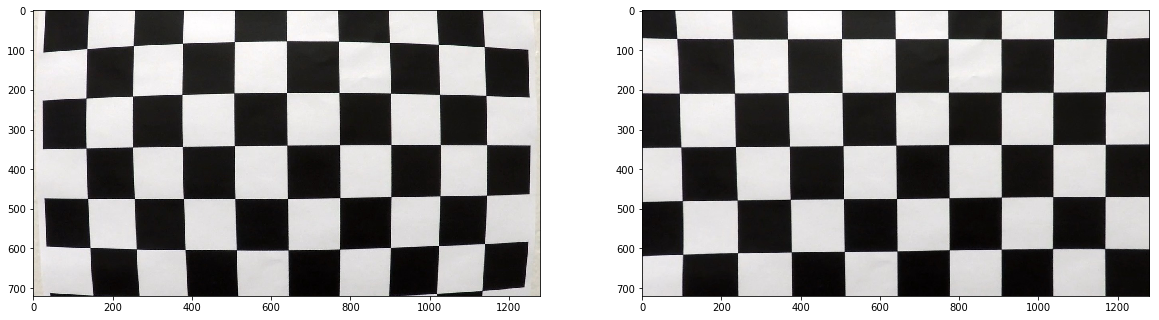

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

img = RoadImage(filename='camera_cal/calibration1.jpg')

# Do camera calibration given object points and image points
# Calibration is also relative to a given image size
#cal = CameraCalibration('camera_cal/calibration.p')

undist = img.undistort(cal)

f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(undist)

# Look good. Save cal.
cal.save('camera_cal/calibration.p')

The code cell above creates the two lists `objpoints` and `imgpoints` of matching 3D to 2D (pixel) coordinate pairs. This data is the input of the `CameraCalibration` constructor, which calculates the parameter set we need to undistort the images and stores it in the instance `cal`. Note that 3D coordinates are in an arbitrary set of axes, and in our case, the axes are local to the chessboard pattern, giving integer coordinates (0,0,0) to (8,5,0). All the points are in the Z=0 plane, which is the plane of the chessboard.

`CameraCalibration` is part of my object oriented package 'classes' (yes, I will rename it: i was discovering python classes, modules and packages for this project). The entire source code is available for review, but it is rather long and somewhat complex, and I have described it in greated detail later.

`CameraCalibration` is a class __which never handles pixels__. It was my first class, and I copied examples from the net to see how object oriented python worked. It contains useless functionality, such as a limitation of the number of instances of the class. Those parts will be deleted (everything is under version control with Git). They haven't yet because I focused on implementing useful functionality, and those useless parts work well and do no harm.

Beyond storing the information necessary to undistort the images, the class also handles all the geometry calculations (methods `lane_start()` at line 224, and `lane()` at line 258). Of course, it was possible to finish this project with a hardcoded trapeze warped into a rectangle and back. The method `lane()` actually computes the coordinates of the trapeze and the rectangle as a function of information provided by the camera calibration:
* Camera optical center: it gives the direction the image plane is orthogonal to, and it is available in the camera calibration matrix;
* Camera x-direction and y-direction focal length, which is relative to the sensor image size and directly gives the horizontal and vertical fields of view;
* Sensor image size, which has to be provided when the calibration and made, and which we store (the size is checked for each image we undistort);
* "Ahead" vector: pointing from the camera into the forward direction of the car;

I hope that I have correctly worked out the 3D geometry problem: the camera in our case is imperfect, but not very much, and errors in my equations might be difficult to notice in the result.
* The camera sensor size is 1280 x 720 pixels;
* The geometric center of that image is at (640, 360), but the optical center is slightly offset, at (670, 386);
* The focal length corresponds to a horizontal field of view of 58° and a vertical field of view of 35°; 
* The "ahead" vector points at pixel (638,418), roughly 1.6° to the left and down of the optical center;
* The height of the camera above the ground, measured at 1.275 m.

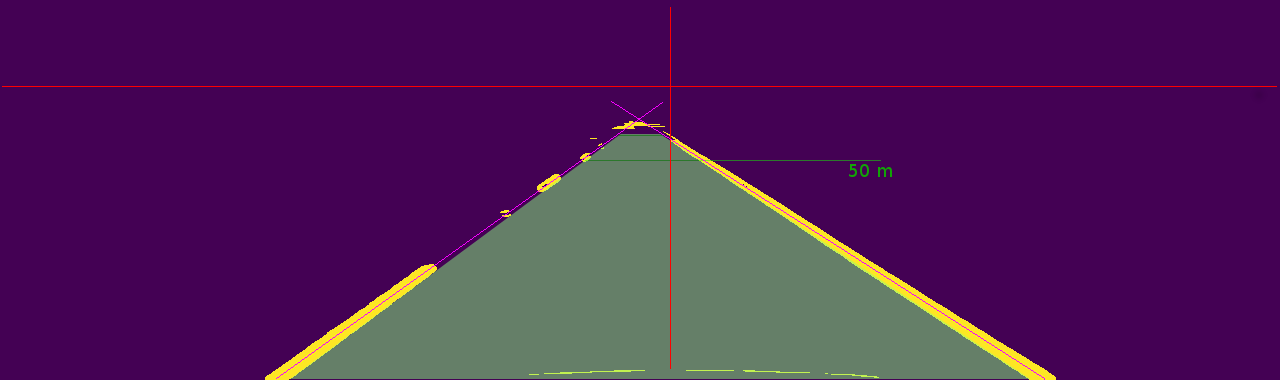

In addition to those never changing parameters (the first one depends on the camera model, the second on the camera instance, and the third and fourth mostly depend on the camera orientation and position relative to the car), the calculation depends on the relative height map, which is a height profile of the road transformed in the car axes given by the "ahead" vector. In those axes, it is not the absolute slope of the road which is described, but the increases or decreases of the slope.

The height profile is partially implemented. The video is made with the assumption of a flat road, but the slope of the road is actually changing.

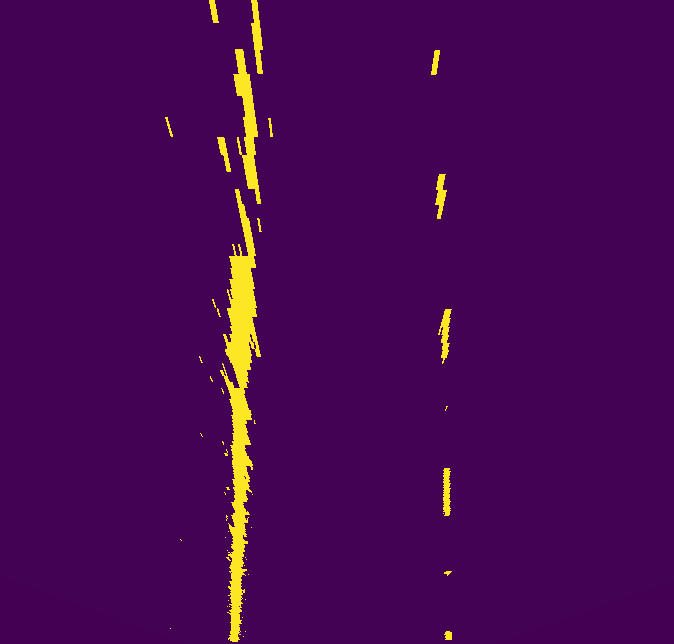

The image above is a composite image showing the lane line pixels for the `straight_lines1.jpg` test image. The scale is 2 cm/pixel in X and 10 cm/pixel in Y and the image is 644 pixels high (almost all the warped image examples use this scale, and a little bit more than 5 meters just ahead of the camera, are not visible in the images). 

It is noticeable that the lines are converging at the top, although they are parallel in reality. A small -18.6 cm correction at 70 meters from the camera makes them exactly parallel. It is reasonable to assume that the lanes are indeed parallel. With this assumption, we can interpret the varying lane width as height changes:
* The lane is too narrow when the height is negative (the road climbs less or descends more ahead);
* The lane is too wide when the height is positive (the road climbs more or descends less ahead).

Note that extracting the lane line pixels at 70 m requires a very good lane detection algorithm. Color alone will not achieve that, even in multiple colorspaces.

At line 324, you will notice that the returned rectangle is in reality a parallelogram. The trapeze is not symmetrical either, because its far end is offset since the camera points to the right of the "ahead" vector. 

I mentioned before that the optical center is important because it is the direction image planes are orthogonal to. Because the optical center is not vertically aligned with the ahead vector, those image planes do not cut the flat "road plane" (discounting the height map) on lines parallel to the X axis of the image. The top and bottom sides of the "rectangle" have a small angle because those sides are the intersection of the image planes passing at the start and the end of the depicted lane. 

Those small angles on the top and bottom sides of the "rectangle" allow the trapeze to have its top and bottom sides of course parallel to each other, but also parallel to the X direction of the image.

---

The next stage of analysis operates in a bird-eye view of the road. A view from above will make it a lot easier to calculate the geometry of the road ahead, especially the position of the car in the lane and the curvature of the road.

In order to get this view, we can rely on OpenCV's `warpPerspective` function. We will just assume that the road ahead lays in a plane having the exact same orientation as the road portion the car sits on. If this assumption isn't true, the lane lines will not be parallel, so we can possibly iterate later to fix that.

Given that assumption, an elongated rectangle of straight road ahead of the car looks like a trapeze in the camera image. We only need to find that trapeze on a suitable stretch of road, and project its four corners on the four corners of an elongated rectangle, representing the road seen from above. 

We will also take the opportunity of this projection to set the scale of the image. The height of the camera above the road sets the scale for everything else. In order to find an acceptable approximation to this figure, we will assume that the lane in the test image "straight_lines1.jpg" is exactly 3.7 meters. We can expect to have a lot more detail across the road, especially at short ranges, than alongside it, therefore we will employ rectangular pixels in the transformed picture. The resolution across the road must be fine enough to capture the thin lines, so we will pick 0.02 meters. In the direction of the road, 0.1 meters will be enough. A stripe 10 meters wide by 70 meters long will require 500 x 700 pixels.

Some calculations using the camera matrix lead to estimates of the field of view (58°), of the height of the camera above the road and give the pixel coordinates of the vertices defining a trapezoidal area representing a 40m long lane straight ahead. Coordinates are not obvious because the camera axis is slightly offset to the right and top. 

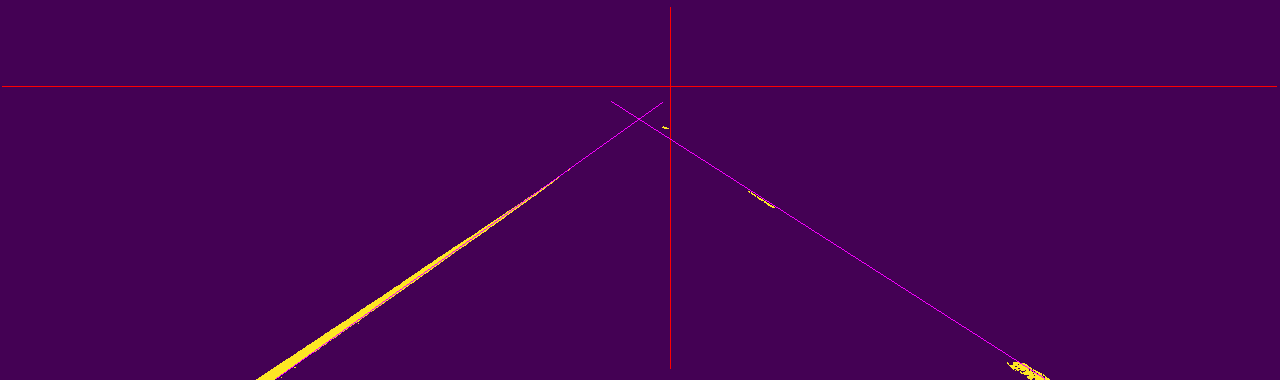

The comparison of the two straight line test images prooves that it is not the trajectory of the car that obliques across the lanes. On the two figures above, which show the lanes extracted from both straight line test images, the magenta lines which are in a separate layer, superpose exactly with the lane lines in both images. The arctangent of the pixel distance, divided by the pixel focal length (found in the camera matrix), gives the angles of misalignment : the camera axis is offset roughly 1.6° to the right and the top from the straight ahead axis defined by the road.

The center of the image is also available in the camera matrix. Taking into account the cropped areas at the top and bottom, the red lines in the figures above cross at the image center, at point (x=670, y=86). Let's consider the vertical plane parallel to the image plane, which meets the ground at the bottom edge of the image. The y coordinate is 379, the last line of the cropped image. The height of the camera axis is 294 pixel lines.

We need a known distance to calculate the scale of everything. The course teaches that the lane width is 3.7 meters. We can observe that the distance is 764 pixel horizontally. Given that those distances are in the same plane parallel to the image plane, the physical distances are proportional to the pixel distances: it gives us the height of the camera above the ground: 1.44 meters (actually the height of the camera axis as it crosses the plane).

Knowing that 3.7 meters appear as 764 pixels, we can convert the focal length to meters using proportionality. The focal length is 5.6 meters. Since the camera is not pointed straight ahead, the camera axis raises above the ground with distance with an angle of 1.6°. At z=70 meters, the small angle adds some to the camera height, which reaches 3.4 meters above the ground. The pixel offset from the image center, is equal to f y/z, using the focal length in pixels to obtain pixels. z can optionally be corrected for the small angle too.

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Mathematically computed trapeze (could be replaced by formulas for a changing slope)
# 40 m trapeze
#TRAPEZE=np.array([[275,379],[584.6,159.6],[691.4,159.6],[1030,379]], dtype=np.float32)
# 70 m trapeze
TRAPEZE=np.array([[275,379],[607.5,141.8],[668.5,141.8],[1030,379]], dtype=np.float32)
# X scale :  2 cm per pixel
# Y scale : 10 cm per pixel
# Receive 40 m in 400 pixels high image
#LANE=np.array([[157.5,399],[157.5,  0],[342.5,  0],[342.5,399]],  dtype=np.float32)
# Receive 70 m in 700 pixels high image
LANE=np.array([[157.5,699],[157.5,  0],[342.5,  0],[342.5,699]],  dtype=np.float32)

persp_mat = cv2.getPerspectiveTransform(TRAPEZE,LANE)
persp_mat_inv = cv2.getPerspectiveTransform(LANE,TRAPEZE)

def camera_to_birdeye(image,persp_mat):
    # Perspective transform
    birdeye_lanes = cv2.warpPerspective(image,  persp_mat, dsize=(500,700))
    return birdeye_lanes

# Demonstration
img = mpimg.imread('output_images/lines_test2.png')    # Read to RGB pixel format 

lanes = camera_to_birdeye(img[300:680],  persp_mat)

# Draw on images
for p1,p2 in zip(TRAPEZE[:3]+[0,300],TRAPEZE[1:]+[0,300]):
    cv2.line(img, tuple(p1.astype(int)), tuple(p2.astype(int)), color=[255,0,0], thickness=3)

#show_lanes = cv2.cvtColor(lanes, cv2.COLOR_GRAY2RGB)
for p1,p2 in zip(LANE[:3],LANE[1:]):
    cv2.line(lanes, tuple(p1.astype(int)), tuple(p2.astype(int)), color=[1,0,0], thickness=3)

from classes import RoadImage

print(persp_mat)

print(img.shape)    
print(lanes.shape, np.min(lanes), np.max(lanes))
# Visualize masks

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
img.view(RoadImage).show(ax1, title='Input')

[[ -5.22778175e-01  -2.03499526e+00   5.79000933e+02]
 [ -2.10942375e-15  -6.28716949e+00   8.91520653e+02]
 [ -3.68628739e-18  -8.26781034e-03   1.00000000e+00]]
(720, 1280, 4)
(700, 500, 4) 0.0 1.0


The images show lane lines, 

In [4]:
from classes import RoadImage, CameraCalibration,Line
from classes.decorators import static_vars
import numpy as np

cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.set_camera_height(1.275)
cal.set_ahead(638,418)

@static_vars(counter=0, img=None)
def process_image(image):
    if process_image.img is None:
        process_image.img = RoadImage(image, src_cspace='RGB')
    else:
        np.copyto(process_image.img, image)
    # Save crash image (in case of crash)
    process_image.img.save('output_images/crash.jpg', format='jpg')
    # Do the work
    process_image.counter += 1
    overlay = process_image.img.find_lines(cal, method = RoadImage.centroids, save=True)
    overlay.save('output_images/videos/image%04d.png' 
                 % process_image.counter)
    out = overlay.to_int().copy()
    del overlay
    return out

AttributeError: 'CameraCalibration' object has no attribute 'set_camera_height'

origin = [215 700]
scoring: 0 -2.43263452431 0.268461751248
DEBUG: p(0,0)= ([15.608377960865795, -2.8460413593667733, 0.041340683505983813, 0.0],)
scores: cust=0.27  weight=0.04  derbounds=0.19
scoring: 0 -0.478390089958 0.950414447988
DEBUG: p(1,0)= ([3.7731598392498982, -0.55958903666703252, 0.0081198946708906702, 0.0],)
scores: cust=0.95  weight=0.08  derbounds=0.54
scoring: 0 -0.504347358159 0.94504206898
DEBUG: p(2,0)= ([3.9356992902761347, -0.58966112835641626, 0.0085313770196958037, 0.0],)
scores: cust=0.95  weight=0.08  derbounds=0.52
scoring: 0 -0.83183118065 0.857473386783
DEBUG: p(3,0)= ([5.7886963445004129, -0.97332416907439168, 0.014149298842421896, 0.0],)
scores: cust=0.86  weight=0.06  derbounds=0.35
scoring: 0 -0.00976179195542 0.999978824095
DEBUG: p(4,0)= ([0.77705585133362987, -0.011633784488619245, 0.00018719925332004255, 0.0],)
scores: cust=1.00  weight=0.62  derbounds=0.94
scoring: 0 -0.750965338101 0.882212796281
DEBUG: p(5,0)= ([5.3205511315158756, -0.8784627168

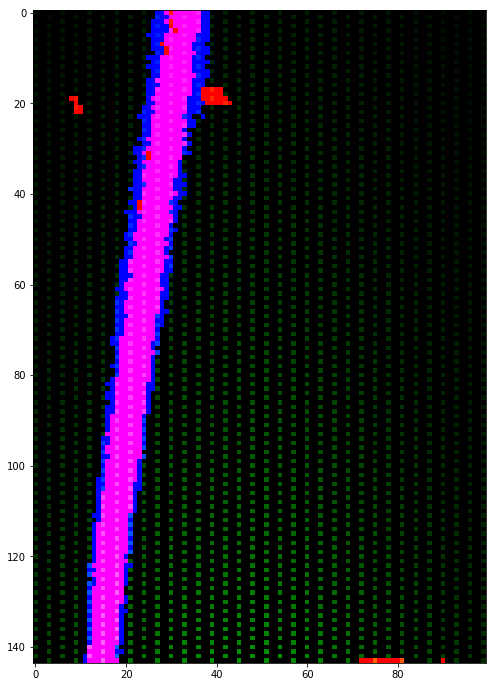

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
image = RoadImage(filename='test_images/test6.jpg')
image = process_image(image)

image=image.to_float()

width = 0.12
sx,sy = (.02,.1)
o = (215,700)

stepx = max(int(width/sx),2)
stepy = max(int(width/sy),2)
startx = stepx//2
starty = stepy//2
iterx  = stepx - startx
itery  = stepy - starty
#iters = ( (x,y) for y in range(1,651,stepy) for x in (3,430,stepx) )
w1 = np.array([ [ weight(y=(x-o[0])*sx+1,x=(o[1]-y)*sy,x0=1,z0=10.) for x in range(3,430,stepx) ] for y in range(1,651,stepy)])
w2 = np.array([ [ weight(y=(x-o[0])*sx+1,x=(o[1]-y)*sy,x0=1,z0=10.) for x in range(3+startx,430,stepx) ] for y in range(1+starty,651,stepy)])

image.view(np.ndarray)[1::stepy,3::stepx,1]=w1
image.view(np.ndarray)[1+starty::stepy,3+startx::stepx,1]=w2
image = image[500:644,120:220]
#image = image[1::stepy,3::stepx]

f, ax1 = plt.subplots(1,1, figsize=(20,12))
image.show(ax1)

In [4]:
print(image.lines._geom.keys())

key=('left',1)
key=('right',1)
for k in image.lines._geom[key].keys():
    print(k+' =',image.lines._geom[key][k])


dict_keys([('zero',), ('right', 1, 'stage1'), ('minusone',), ('tmpright', 1), ('save', 1), ('right', 1, 'stage4'), ('left', 1), ('lane', 0), ('left', 1, 'stage4'), ('right', 1), ('left', 1, 'stage1'), ('right', 1, 'stage2'), ('left', 1, 'stage2'), ('left', 0), ('left', 1, 'stage0'), ('right', 1, 'stage0'), ('tmpleft', 1), ('one',), ('right', 0)])
zmax = 63.7037037581
op = wsum
w2 = 0.166673896982
eval = 476.5756207108207
w1 = 0
wsco = 0.999964215657
csco = 0.99999240458
poly = [2.0697505164957621, -0.010660175497828009, 0.00076015988834906092, 2.8847538933146128e-06, -4.8657731189475674e-08]
order = 4
dsco = 1.0
dens = 1


Separation... avoids scrolling

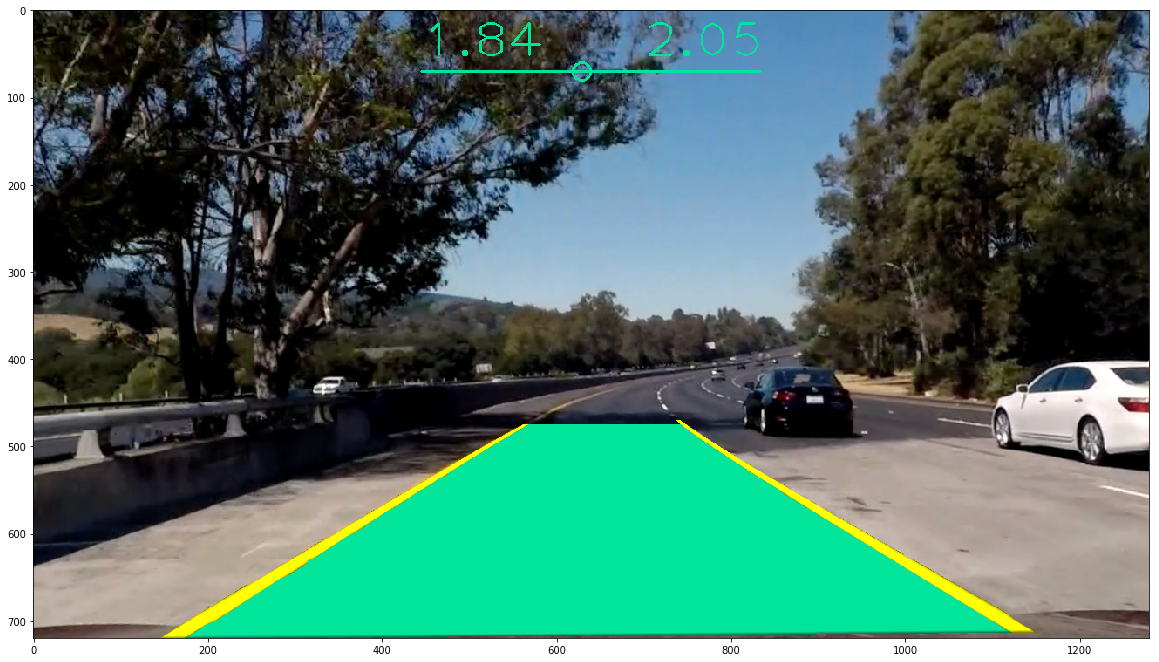

In [2]:
import numpy as np
#import pdb
#%pdb

def myweight(x,y,x0=0.5,z0=100):
    return np.exp(-x**2/z0**2)*np.exp(-y**2/x0**2)

def plotweight(img, key, origin, scale, x0, z0):
    if not(img.lines.exist(key)): return
    w,h = img.get_size()
    ox,oy = origin
    sx,sy = scale
    for y in range(h):
        x=(oy-y)*sy
        yref = img.lines.eval(key,z=x)
        xx = np.arange(w)
        yy = np.ones_like(xx)*y
        weights = myweight(y=(xx-ox)*sx-yref,x=(oy-yy)*sy,x0=x0,z0=z0)
        img[y,:,1] = np.maximum(img[y,:,1], weights)
        
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

#file='input0001'
#file='input0073'
#file='input0604'
#file='input1210'
#file='input1230'
file='test1'
file='test5'

image = RoadImage(filename='test_images/'+file+'.jpg')
#process_image.state=None
image = process_image(image)

f, ax1 = plt.subplots(1,1, figsize=(20,14))
image.show(ax1)

Warning: About to reinitialize!

In [1]:
from classes import CameraCalibration, RoadImage
from classes.decorators import static_vars
#import pdb
#%pdb
cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.camera_height=1.2
cal.set_ahead(638,418)

@static_vars(state=None)
def process_image(image):
    img = RoadImage(image, src_cspace='RGB')
    img = img.undistort(cal)
    RoadImage.find_lines.state = process_image.state
    img = img.find_lines(cal)
    process_image.state = RoadImage.find_lines.state
    return img

Make the video.

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pdb
%pdb

process_image.state=None
file = 'project_video.mp4'
#file = 'challenge_video.mp4'
output = 'output_images/'+file
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(file).subclip(37,42)
clip1 = VideoFileClip(file).subclip(20,25)
#clip1 = VideoFileClip(file)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

Automatic pdb calling has been turned ON
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


 99%|█████████▉| 125/126 [02:14<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 2min 46s, sys: 2min 53s, total: 5min 40s
Wall time: 2min 16s


In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))